In [1]:
import numpy as np
import pylab as plt
import healpy as hp
import pyradiosky

from pyuvdata import UVData

import sys
sys.path.append("/home/phil/hera/Hydra") # change this to your own path
import hydra

from hera_sim.visibilities import VisibilitySimulation, ModelData, VisCPU
from hera_sim import io
#from hera_sim.beams import PolyBeam, PerturbedPolyBeam
from hera_sim import Simulator
import pyuvsim

from astropy import units
import time

In [2]:
lmax = 5

# Array of ell, m values in healpy ordering
ell, m = hp.Alm().getlm(lmax=lmax)
for n in range(ell.size):
    print("idx = %d, ell = %d, m = %d" % (2*n, ell[n], m[n]))

alm = np.zeros(ell.size, dtype=np.complex128)

idx = 0, ell = 0, m = 0
idx = 2, ell = 1, m = 0
idx = 4, ell = 2, m = 0
idx = 6, ell = 3, m = 0
idx = 8, ell = 4, m = 0
idx = 10, ell = 5, m = 0
idx = 12, ell = 1, m = 1
idx = 14, ell = 2, m = 1
idx = 16, ell = 3, m = 1
idx = 18, ell = 4, m = 1
idx = 20, ell = 5, m = 1
idx = 22, ell = 2, m = 2
idx = 24, ell = 3, m = 2
idx = 26, ell = 4, m = 2
idx = 28, ell = 5, m = 2
idx = 30, ell = 3, m = 3
idx = 32, ell = 4, m = 3
idx = 34, ell = 5, m = 3
idx = 36, ell = 4, m = 4
idx = 38, ell = 5, m = 4
idx = 40, ell = 5, m = 5


In [3]:
def empty_uvdata(ants=None, nfreq=20, ntimes=20, bandwidth=0.2e8, 
                 integration_time=40., 
                 start_time=2458902.33333, start_freq=1.e8, **kwargs):
    """
    Generate empty UVData object with the right shape.
    
    Parameters
    ----------
    ants (dict): None
        A dictionary mapping an integer to a three-tuple of ENU co-ordinates for
        each antenna. These antennas can be down-selected via keywords.
    ntimes : int, optional
        Number of time samples. Default: 20.
    
    bandwidth : float
        Total bandwidth, in Hz. Default: 0.2e8
    
    integration_time : float, optional
        Integration time per time sample. Default: 40. 
    
    start_time : float, optional
        Start date of observations, as Julian date. Default: 2458902.33333 
        (20:00 UTC on 2020-02-22)
    
    start_freq : float, optional
        Initial frequency channel, in Hz. Default: 1.e8.
    
    **kwargs : args
        Other arguments to be passed to `hera_sim.io.empty_uvdata`.
    
    Returns
    -------
    uvd : UVData
        Returns an empty UVData 
    """
    uvd = io.empty_uvdata(
        Nfreqs=nfreq,
        start_freq=start_freq,
        channel_width=bandwidth / nfreq,
        start_time=start_time,
        integration_time=integration_time,
        Ntimes=ntimes,
        array_layout=ants,
        **kwargs
    )
    
    # Add missing parameters
    uvd._x_orientation.value = 'east'
    return uvd

[0.+0.j 1.+0.j 0.+0.j]


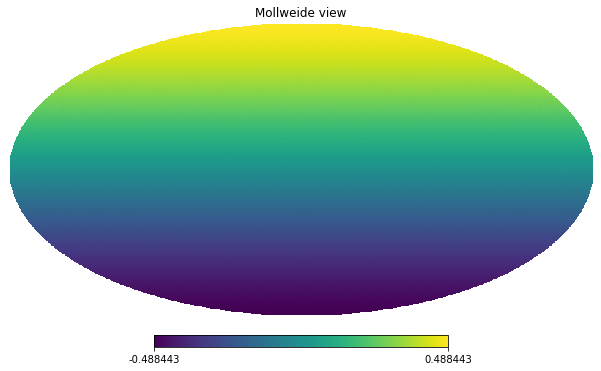

In [199]:
def sh_sky_model(alms, nside=32):
    """
    Return a pyradiosky SkyModel object populated with a map generated from 
    spherical harmonics.
    
    Parameters
    ----------
    alms : array_like, optional
        Values of the spherical harmonics, in Healpix ordering.
    nside : int, optional
        Healpix nside.
    Returns
    -------
    sky_model : pyradiosky.SkyModel
        SkyModel object.
    """
    #dec, ra = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=False)

    # Get datacube properties
    npix = hp.nside2npix(nside)
    pix_area = 4.*np.pi / npix # steradians per pixel
    indices = np.arange(npix)
    history = "healpy spherical harmonics, data_unit=Jy/sr, resolution=low, freq_unit=MHz"
    #freq = units.Quantity(freqs, "hertz")
    
    # Generate map from alms
    hpmap_units = "Jy/sr"
    hpmap = hp.alm2map(alm, nside=nside) #* pix_area
    # FIXME: pix_area make the values v. small, so scale up to a big value
    
    # hmap is in Jy
    stokes = units.Quantity(np.zeros((4, 1, len(indices))), hpmap_units)
    stokes[0] = hpmap * units.Unit(hpmap_units)
    
    hp.mollview(hpmap)
    plt.show()
    
    # Construct pyradiosky SkyModel
    sky_model = pyradiosky.SkyModel(
                                    nside=nside,
                                    hpx_inds=indices,
                                    stokes=stokes,
                                    spectral_type="flat",
                                    #freq_array=freq,
                                    history=history,
                                    frame="icrs",
                                    hpx_order="ring"
                                )

    #sky_model.healpix_interp_transform(frame='icrs', full_sky=True, inplace=True) # do coord transform
    #assert sky_model.component_type == "healpix"
    return sky_model


alm *= 0.
alm[0] = 0.
alm[1] = 1.
#alm[2] = 0. #1. + 0.j
print(alm)
#freqs = np.linspace(100e6, 120e6, 4)

sh_sky = sh_sky_model(alm, nside=32)

In [104]:
ant_pos = {0: (0., 0., 0.), 
           1: (14., 0., 0.),
           2: (0., 14., 0.),
           3: (14., 14., 0.),
           4: (40., 0., 0.),
          }
beams = [pyuvsim.AnalyticBeam('gaussian', sigma=np.deg2rad(30.)) for ant in ant_pos]

In [234]:
uvd = empty_uvdata(ants=ant_pos, nfreq=3, ntimes=11, bandwidth=0.2e8, 
                   integration_time=40., 
                   start_time=2458902.33333, start_freq=1.e8)

def viscpu_sh(uvd, alm, nside=32):
    uvd.data_array *= 0.
    
    # Spherical harmonic sky model
    sh_sky = sh_sky_model(alm, nside=nside)
    
    # Construct a data model
    data_model = ModelData(uvdata=uvd, 
                           sky_model=sh_sky,
                           beams=beams)

    # Initialise VisCPU handler object
    viscpu = VisCPU(precision=2, mpi_comm=None, correct_source_positions=True) # FIXME!

    # Create a VisibilitySimulation object
    simulator = VisibilitySimulation(data_model=data_model, 
                                     simulator=viscpu)

    # Run the simulation
    tstart = time.time()
    simulator.simulate()
    print("Simulation (diffuse) took %2.1f sec" % (time.time() - tstart))

    # Extract visibilities
    #uvd.get_data(0,0)
    return uvd

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


[ 0.        +0.j          0.70710678+0.j          0.        +0.j
  0.        +0.j         -0.46984631+0.17101007j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j        ]


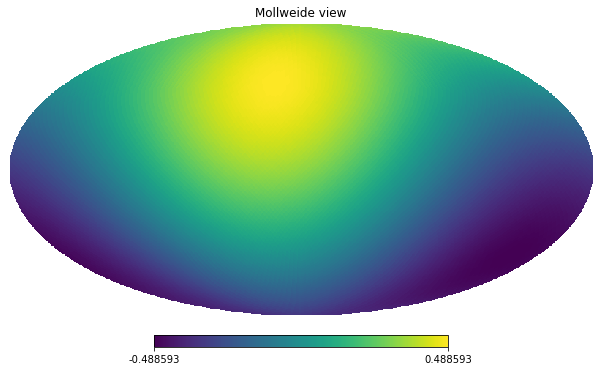

In [106]:
alm *= 0.
alm[1] = 1.
hp.rotate_alm(alm, 0., np.deg2rad(45.), np.deg2rad(20.))
print(alm)

hp.mollview(hp.alm2map(alm, nside=32))

In [107]:
lmax = 3
nside = 128

# Array of ell, m values in healpy ordering
ell, m = hp.Alm().getlm(lmax=lmax)
for n in range(ell.size):
    alm = np.zeros(ell.size, dtype=np.complex128)
    
    alm[n] = 1.
    hpmap = hp.alm2map(alm, nside=nside)
    c1 = np.sum(np.abs(hpmap))
    star = "*" if c1 < 1e-6 else ""
    print("idx = %d, ell = %d, m = %d, sum(abs) = %5.3e %s" % (2*n, ell[n], m[n], c1, star))
    
    alm[n] = 1.j
    hpmap = hp.alm2map(alm, nside=nside)
    c1 = np.sum(np.abs(hpmap))
    star = "*" if c1 < 1e-6 else ""
    print("idx = %d, ell = %d, m = %d, sum(abs) = %5.3e %s" % (2*n+1, ell[n], m[n], c1, star))

idx = 0, ell = 0, m = 0, sum(abs) = 5.546e+04 
idx = 1, ell = 0, m = 0, sum(abs) = 0.000e+00 *
idx = 2, ell = 1, m = 0, sum(abs) = 4.803e+04 
idx = 3, ell = 1, m = 0, sum(abs) = 0.000e+00 *
idx = 4, ell = 2, m = 0, sum(abs) = 4.773e+04 
idx = 5, ell = 2, m = 0, sum(abs) = 0.000e+00 *
idx = 6, ell = 3, m = 0, sum(abs) = 4.769e+04 
idx = 7, ell = 3, m = 0, sum(abs) = 0.000e+00 *
idx = 8, ell = 1, m = 1, sum(abs) = 6.793e+04 
idx = 9, ell = 1, m = 1, sum(abs) = 6.793e+04 
idx = 10, ell = 2, m = 1, sum(abs) = 6.446e+04 
idx = 11, ell = 2, m = 1, sum(abs) = 6.446e+04 
idx = 12, ell = 3, m = 1, sum(abs) = 6.314e+04 
idx = 13, ell = 3, m = 1, sum(abs) = 6.314e+04 
idx = 14, ell = 2, m = 2, sum(abs) = 6.446e+04 
idx = 15, ell = 2, m = 2, sum(abs) = 6.446e+04 
idx = 16, ell = 3, m = 2, sum(abs) = 6.396e+04 
idx = 17, ell = 3, m = 2, sum(abs) = 6.396e+04 
idx = 18, ell = 3, m = 3, sum(abs) = 6.152e+04 
idx = 19, ell = 3, m = 3, sum(abs) = 6.152e+04 


## deltaV using VisCPU

In [108]:
lmax = 3
nside = 128

ant1, ant2 = 0, 4

#freqs = np.linspace(100e6, 104e6, 18)
#lsts = np.linspace(0., 2.*np.pi, 60)
latitude = -30.7215 * np.pi / 180.

In [109]:
# Array of ell, m values in healpy ordering
ell, m = hp.Alm().getlm(lmax=lmax)
for n in range(ell.size):
    print("idx = %d, ell = %d, m = %d" % (2*n, ell[n], m[n]))

alm = np.zeros(ell.size, dtype=np.complex128)

idx = 0, ell = 0, m = 0
idx = 2, ell = 1, m = 0
idx = 4, ell = 2, m = 0
idx = 6, ell = 3, m = 0
idx = 8, ell = 1, m = 1
idx = 10, ell = 2, m = 1
idx = 12, ell = 3, m = 1
idx = 14, ell = 2, m = 2
idx = 16, ell = 3, m = 2
idx = 18, ell = 3, m = 3


Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


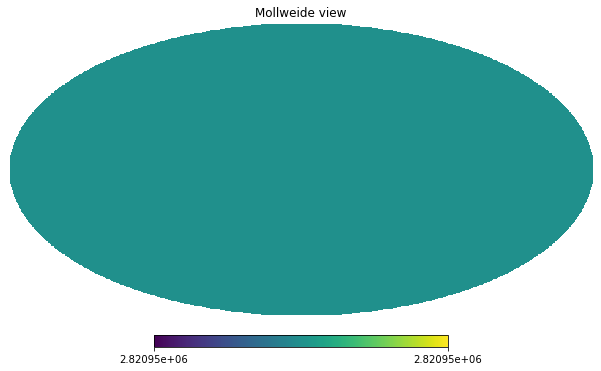

Simulation (diffuse) took 1.4 sec


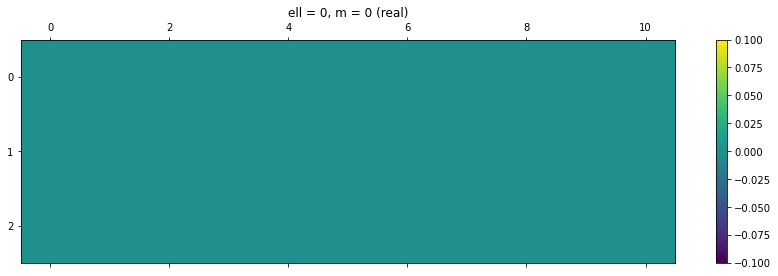

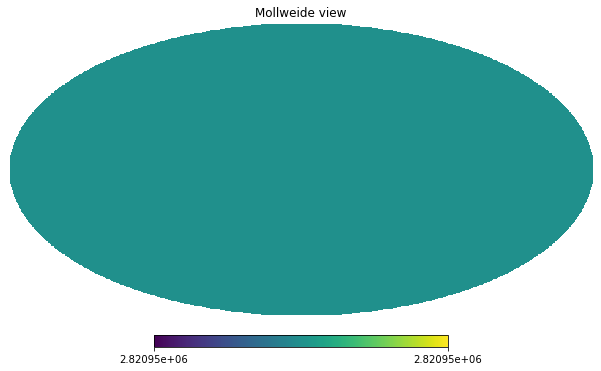

Simulation (diffuse) took 1.4 sec


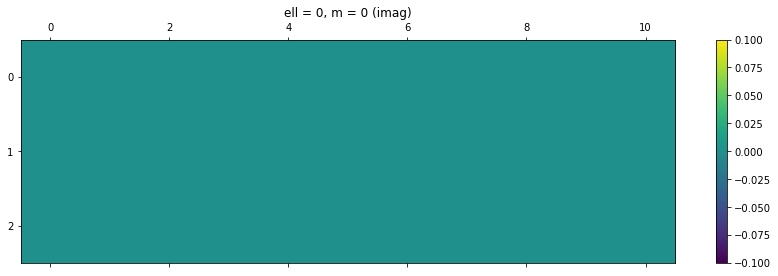

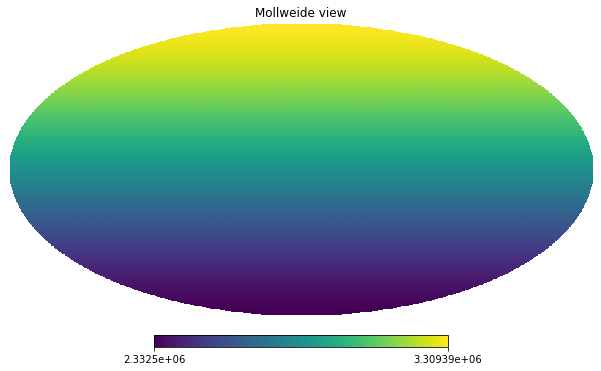

Simulation (diffuse) took 1.3 sec


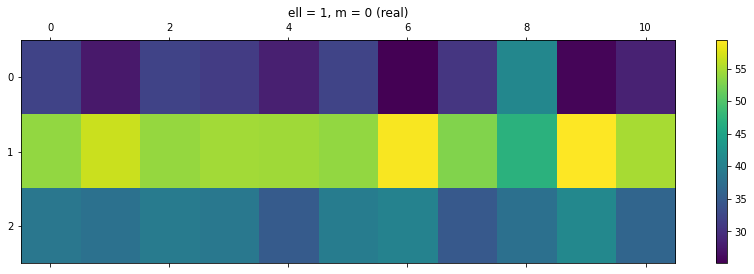

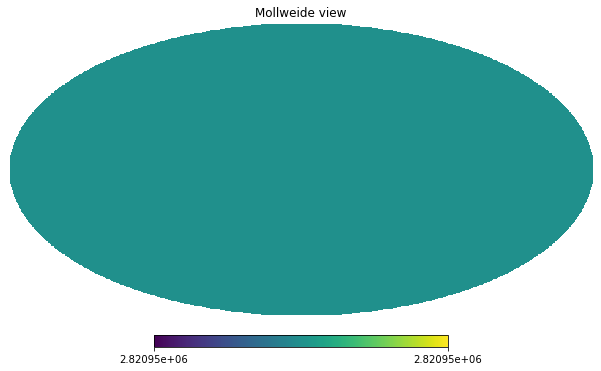

Simulation (diffuse) took 1.4 sec


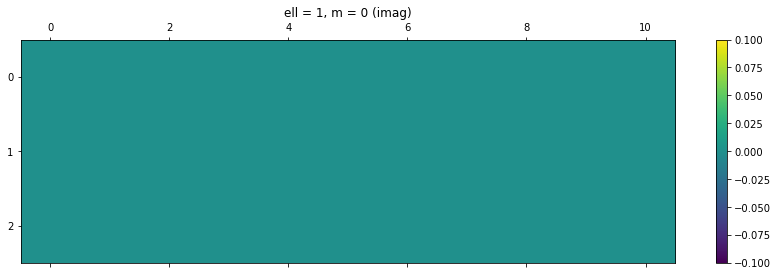

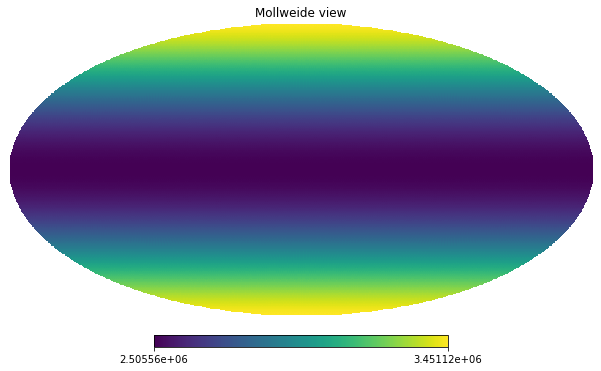

Simulation (diffuse) took 1.4 sec


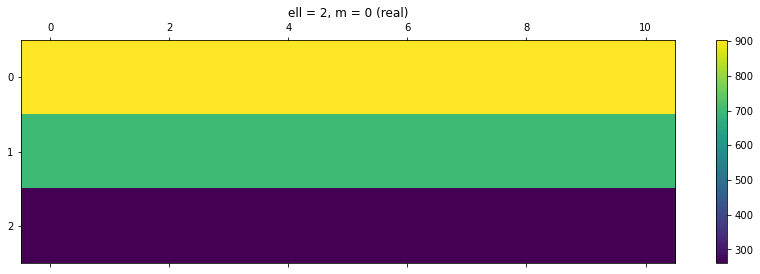

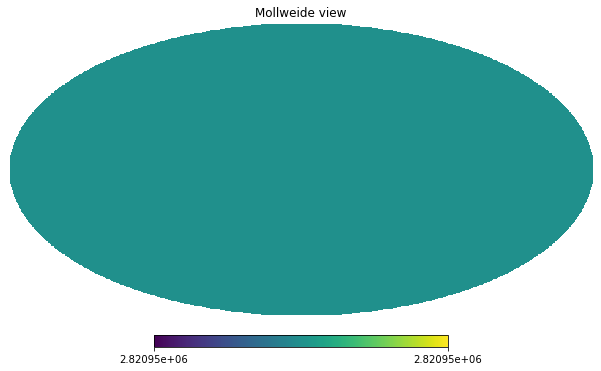

Simulation (diffuse) took 1.4 sec


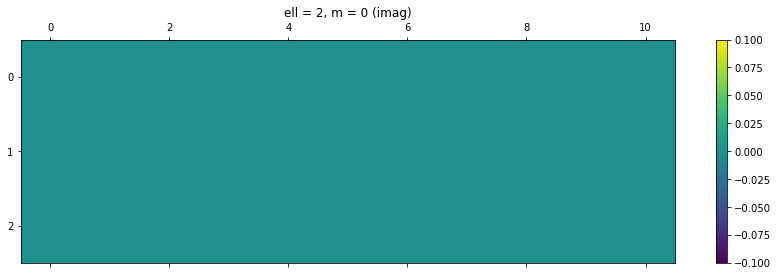

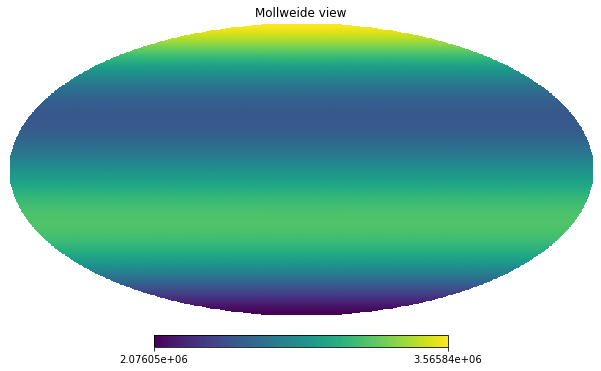

Simulation (diffuse) took 1.3 sec


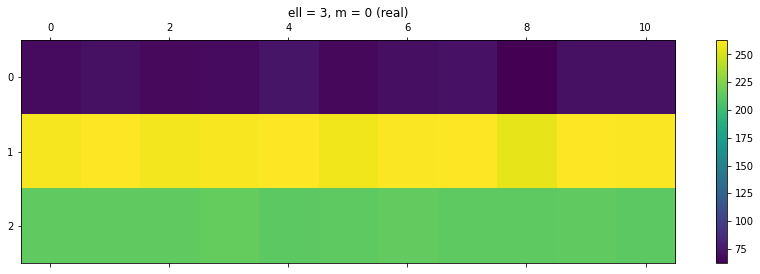

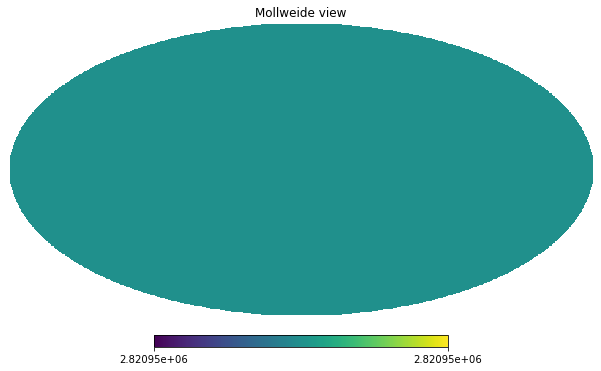

Simulation (diffuse) took 1.4 sec


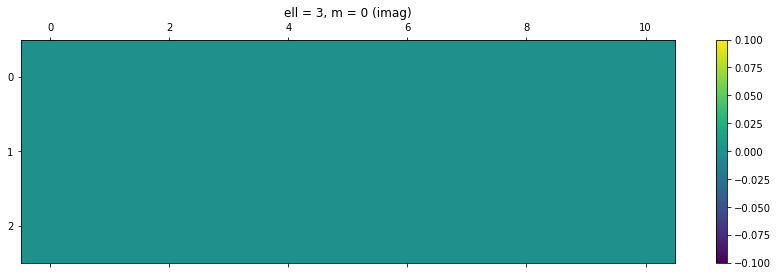

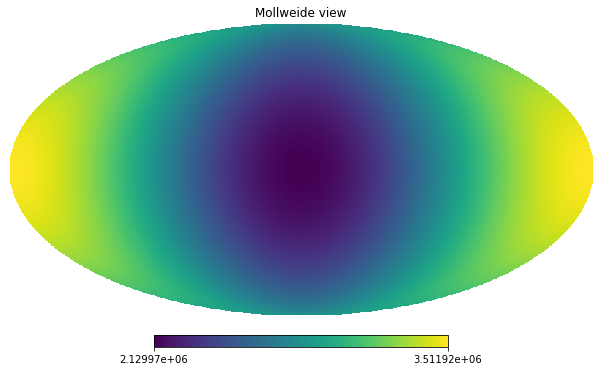

Simulation (diffuse) took 1.4 sec


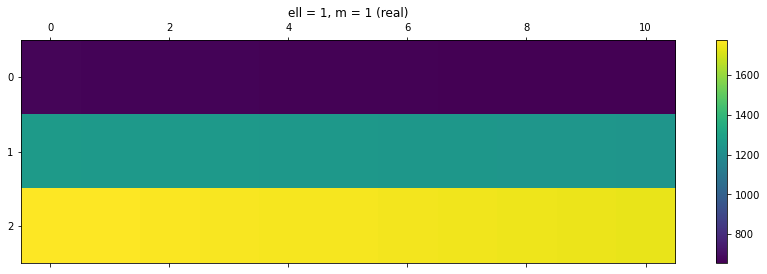

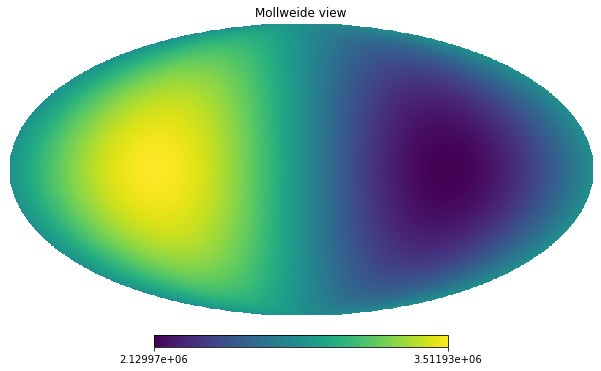

Simulation (diffuse) took 1.4 sec


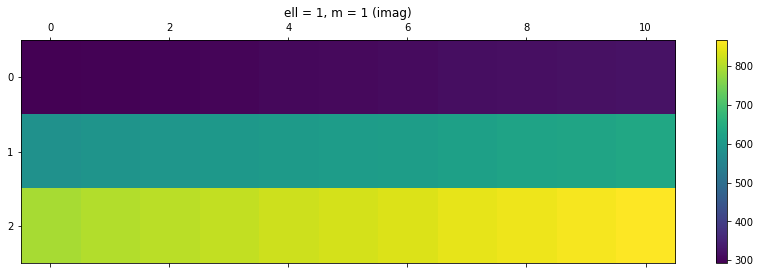

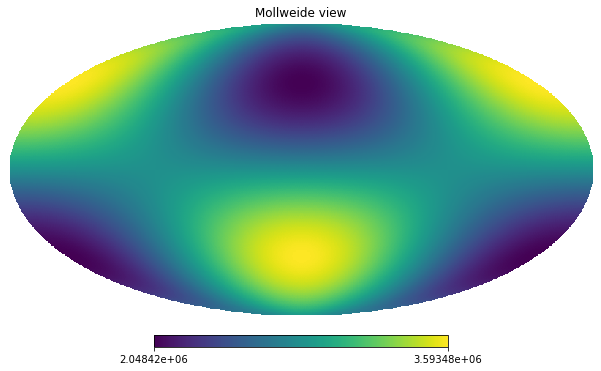

Simulation (diffuse) took 1.4 sec


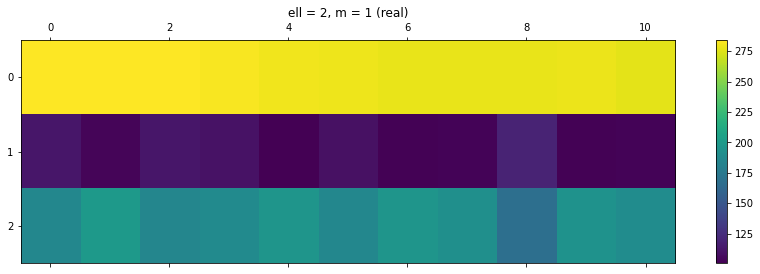

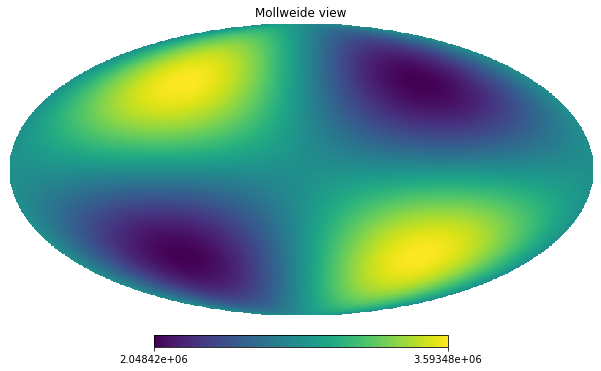

Simulation (diffuse) took 1.4 sec


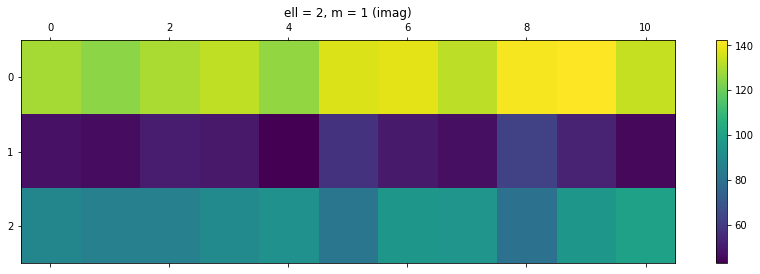

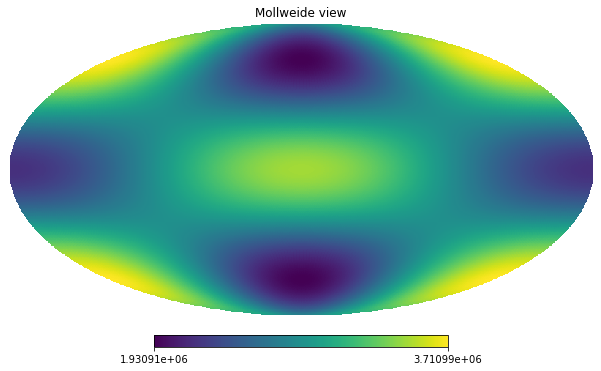

Simulation (diffuse) took 1.4 sec


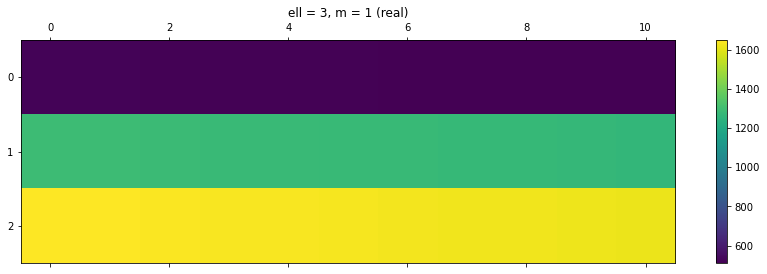

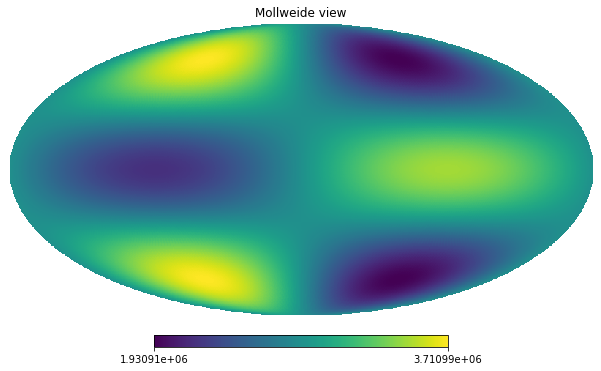

Simulation (diffuse) took 1.3 sec


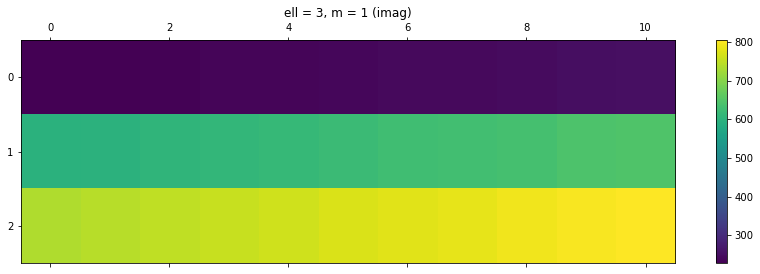

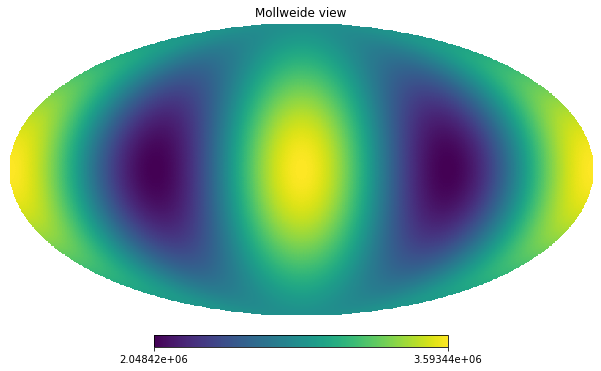

Simulation (diffuse) took 1.4 sec


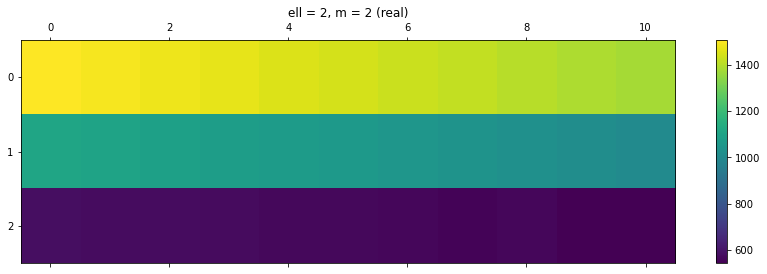

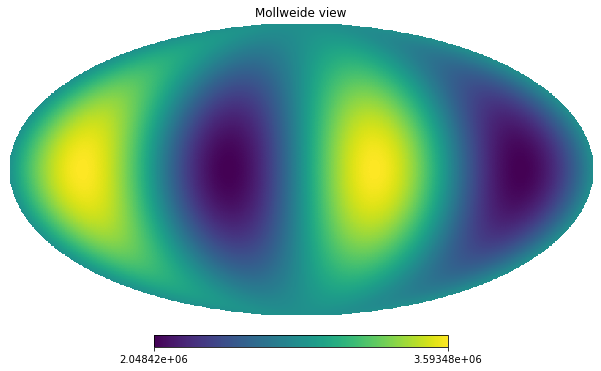

Simulation (diffuse) took 1.4 sec


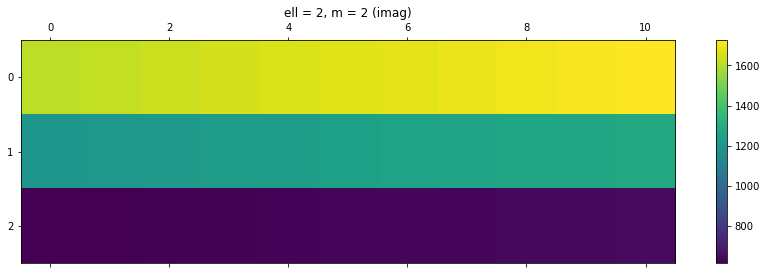

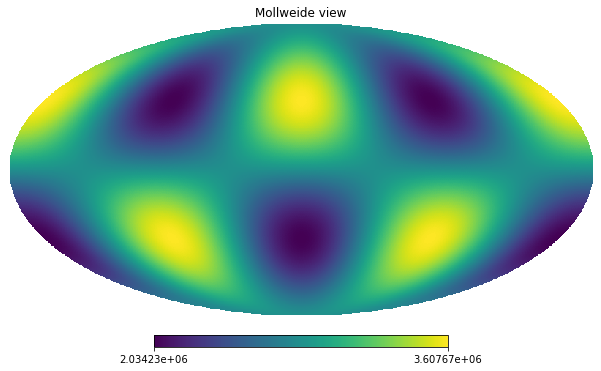

Simulation (diffuse) took 1.4 sec


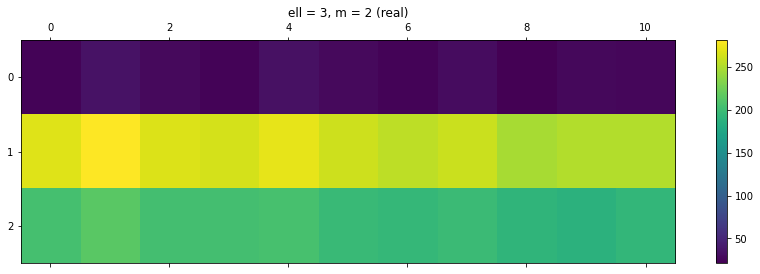

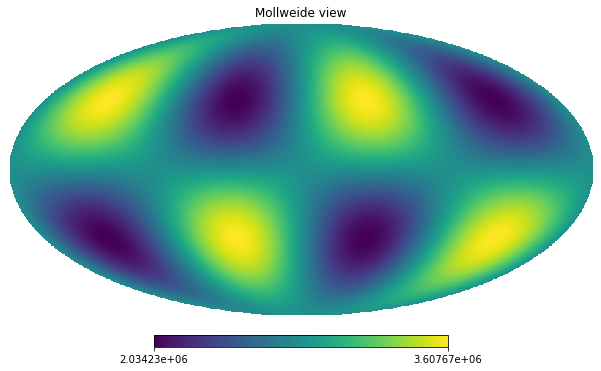

Simulation (diffuse) took 1.4 sec


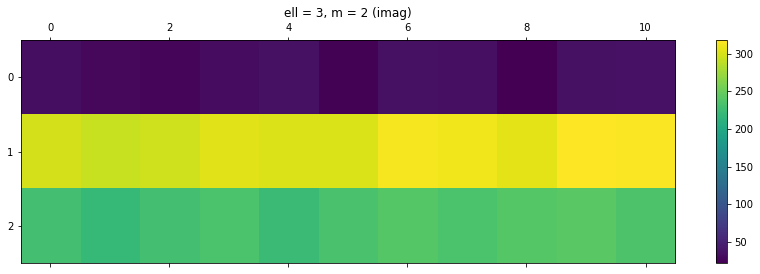

In [110]:
uvd = empty_uvdata(ants=ant_pos, nfreq=3, ntimes=11, bandwidth=4e6, 
                   integration_time=60., 
                   start_time=2458902.33333, start_freq=100e6)

monopole_data = 0
for i in range(ell.size-1):
    
    # Real part
    alm *= 0.
    alm[i] = 1.
    alm[0] = 10. # Have to add monopole for viscpu!
    viscpu_sh(uvd, alm, nside=128)
    
    if i == 0:
        # Save monopole
        monopole_data = uvd.get_data(ant1, ant2).copy()
    
    plt.matshow(np.abs(uvd.get_data(ant1, ant2) - monopole_data).T, aspect='auto')
    plt.title("ell = %d, m = %d (%s)" % (ell[i], m[i], 'real'))
    plt.colorbar()
    plt.show()
    
    # Imag. part
    alm *= 0.
    alm[i] = 1.j
    alm[0] = 10. # monopole!
    viscpu_sh(uvd, alm, nside=128)
    
    plt.matshow(np.abs(uvd.get_data(ant1, ant2) - monopole_data).T, aspect='auto')
    plt.title("ell = %d, m = %d (%s)" % (ell[i], m[i], 'imag'))
    plt.colorbar()
    plt.show()
    



## deltaV operator from Hydra

In [181]:
def simulate_vis_per_source(
    ants,
    fluxes,
    ra,
    dec,
    freqs,
    lsts,
    beams,
    polarized=False,
    precision=2,
    latitude=-30.7215 * np.pi / 180.0,
    use_feed="x",
    multiprocess=False,
    subarr_ant=None
):
    """
    Run a basic simulation, returning the visibility for each source
    separately. Based on ``vis_cpu``.
    This wrapper handles the necessary coordinate conversions etc.
    Parameters:
        ants (dict):
            Dictionary of antenna positions. The keys are the antenna names
            (integers) and the values are the Cartesian x,y,z positions of the
            antennas (in meters) relative to the array center.
        fluxes (array_like):
            2D array with the flux of each source as a function of frequency,
            of shape (NSRCS, NFREQS).
        ra, dec (array_like):
            Arrays of source RA and Dec positions in radians. RA goes from
            [0, 2 pi] and Dec from [-pi, +pi].
        freqs (array_like):
            Frequency channels for the simulation, in Hz.
        lsts (array_like):
            Local sidereal times for the simulation, in radians. Range is
            [0, 2 pi].
        beams (list of ``UVBeam`` objects):
            Beam objects to use for each antenna.
        polarized (bool):
            If True, use polarized beams and calculate all available linearly-
            polarized visibilities, e.g. V_nn, V_ne, V_en, V_ee.
            Default: False (only uses the 'ee' polarization).
        precision (int):
            Which precision setting to use for :func:`~vis_cpu`. If set to
            ``1``, uses the (``np.float32``, ``np.complex64``) dtypes. If set
            to ``2``, uses the (``np.float64``, ``np.complex128``) dtypes.
        latitude (float):
            The latitude of the center of the array, in radians. The default is
            the HERA latitude = -30.7215 * pi / 180.
        multiprocess (bool): Whether to use multiprocessing to speed up the
            calculation
        subarr_ant (int): Used to calculate only those visibilities associated
            with a particular antenna.
    Returns:
        vis (array_like):
            Complex, shape (NAXES, NFEED, NFREQS, NTIMES, NANTS, NANTS, NSRCS)
            if ``polarized == True``, or (NFREQS, NTIMES, NANTS, NANTS, NSRCS)
            otherwise.
    """
    from vis_cpu import conversions
    import os
    
    nsrcs = ra.size

    assert len(ants) == len(
        beams
    ), "The `beams` list must have as many entries as the ``ants`` dict."

    assert fluxes.shape == (
        ra.size,
        freqs.size,
    ), "The `fluxes` array must have shape (NSRCS, NFREQS)."

    # Determine precision
    if precision == 1:
        complex_dtype = np.complex64
    else:
        complex_dtype = np.complex128

    # Get polarization information from beams
    if polarized:
        try:
            naxes = beams[0].Naxes_vec
            nfeeds = beams[0].Nfeeds
        except AttributeError:
            # If Naxes_vec and Nfeeds properties aren't set, assume all pol.
            naxes = nfeeds = 2

    # Antenna x,y,z positions
    antpos = np.array([ants[k] for k in ants.keys()])
    nants = antpos.shape[0]

    # Source coordinate transform, from equatorial to Cartesian
    crd_eq = conversions.point_source_crd_eq(ra, dec)

    # Get coordinate transforms as a function of LST
    eq2tops = np.array([conversions.eci_to_enu_matrix(lst, latitude) for lst in lsts])

    beams = [
        conversions.prepare_beam(beam, polarized=polarized, use_feed=use_feed)
        for beam in beams
    ]

    # Initialise output array
    if polarized:
        vis_shape = (naxes, nfeeds, freqs.size, lsts.size, nants, nants, nsrcs)
    elif subarr_ant is not None:
    # When polarized beams implemented, need to have similar block in  polarized case above
        vis_shape = (freqs.size, lsts.size, nants, nsrcs)
    else:
        vis_shape = (freqs.size, lsts.size, nants, nants, nsrcs)
    vis = np.zeros(vis_shape, dtype=complex_dtype)

    # Parallel loop over frequencies that calls vis_cpu for UVBeam
    # The `global` declaration is needed so that multiprocessing can handle
    # the input args correctly
    global _sim_fn_simulate_vis_per_source
    def _sim_fn_simulate_vis_per_source(i):
        return vis_sim_per_source(
                                  antpos,
                                  freqs[i],
                                  eq2tops,
                                  crd_eq,
                                  fluxes[:, i],
                                  beam_list=beams,
                                  precision=precision,
                                  polarized=polarized,
                                  subarr_ant=subarr_ant,
                                 )
    if multiprocess:
        # Set up parallel loop
        try:
            Nthreads = int(os.environ['OMP_NUM_THREADS'])
        except:
            Nthreads = cpu_count()
        with Pool(Nthreads) as pool:
            vv = pool.map(_sim_fn_simulate_vis_per_source, range(freqs.size))
    else:
        vv = np.zeros_like(vis)
        for i in range(len(freqs)):
            vv[i] = _sim_fn_simulate_vis_per_source(i)

    # Assign returned values to array
    for i in range(freqs.size):
        if polarized:
            vis[:, :, i] = vv[i]  # v.shape: (nax, nfeed, ntimes, nant, nant, nsrcs)
        else:
            vis[i] = vv[i]  # v.shape: (ntimes, nant, nant, nsrcs) (unless subarr_ant is not None)

    return vis


def simulate_vis(
    *args, **kwargs
):
    """
    Run a basic simulation, based on ``vis_cpu``.
    This wrapper handles the necessary coordinate conversions etc.
    Parameters:
        ants (dict):
            Dictionary of antenna positions. The keys are the antenna names
            (integers) and the values are the Cartesian x,y,z positions of the
            antennas (in meters) relative to the array center.
        fluxes (array_like):
            2D array with the flux of each source as a function of frequency,
            of shape (NSRCS, NFREQS).
        ra, dec (array_like):
            Arrays of source RA and Dec positions in radians. RA goes from
            [0, 2 pi] and Dec from [-pi, +pi].
        freqs (array_like):
            Frequency channels for the simulation, in Hz.
        lsts (array_like):
            Local sidereal times for the simulation, in radians. Range is
            [0, 2 pi].
        beams (list of ``UVBeam`` objects):
            Beam objects to use for each antenna.
        polarized (bool):
            If True, use polarized beams and calculate all available linearly-
            polarized visibilities, e.g. V_nn, V_ne, V_en, V_ee.
            Default: False (only uses the 'ee' polarization).
        precision (int):
            Which precision setting to use for :func:`~vis_cpu`. If set to
            ``1``, uses the (``np.float32``, ``np.complex64``) dtypes. If set
            to ``2``, uses the (``np.float64``, ``np.complex128``) dtypes.
        latitude (float):
            The latitude of the center of the array, in radians. The default is
            the HERA latitude = -30.7215 * pi / 180.
        multiprocess (bool): Whether to use multiprocessing to speed up the
            calculation
    Returns:
        vis (array_like):
            Complex, shape (NAXES, NFEED, NFREQS, NTIMES, NANTS, NANTS)
            if ``polarized == True``, or (NFREQS, NTIMES, NANTS, NANTS)
            otherwise.
    """
    # Run simulation using the per-source simulation function
    vis = simulate_vis_per_source(*args, **kwargs)

    # Sum over sources and return
    return np.sum(vis, axis=-1)


def simulate_vis_per_alm(
    lmax,
    nside,
    ants,
    freqs,
    lsts,
    beams,
    polarized=False,
    precision=2,
    latitude=-30.7215 * np.pi / 180.0,
    use_feed="x",
    multiprocess=True
):
    """
    Run a basic simulation, returning the visibility for each spherical harmonic mode
    separately. Based on ``vis_cpu``.
    This wrapper handles the necessary coordinate conversions etc.
    NOTE: The spherical harmonic modes are defined in the equatorial (RA, Dec)
    coordinate system.
    Parameters:
        lmax (int):
            Maximum ell value to simulate.
        nside (int):
            Healpix map nside used to generate the simulations. Higher values
            will give more accurate results.
        ants (dict):
            Dictionary of antenna positions. The keys are the antenna names
            (integers) and the values are the Cartesian x,y,z positions of the
            antennas (in meters) relative to the array center.
        freqs (array_like):
            Frequency channels for the simulation, in Hz.
        lsts (array_like):
            Local sidereal times for the simulation, in radians. Range is
            [0, 2 pi].
        beams (list of ``UVBeam`` objects):
            Beam objects to use for each antenna.
        polarized (bool):
            If True, use polarized beams and calculate all available linearly-
            polarized visibilities, e.g. V_nn, V_ne, V_en, V_ee.
            Default: False (only uses the 'ee' polarization).
        precision (int):
            Which precision setting to use for :func:`~vis_cpu`. If set to
            ``1``, uses the (``np.float32``, ``np.complex64``) dtypes. If set
            to ``2``, uses the (``np.float64``, ``np.complex128``) dtypes.
        latitude (float):
            The latitude of the center of the array, in radians. The default is
            the HERA latitude = -30.7215 * pi / 180.
        multiprocess (bool): Whether to use multiprocessing to speed up the
            calculation
    Returns:
        ell, m (array_like):
            Arrays of integer values of ell, m modes, with the same ordering as
            the modes in the last dimensions of `vis`. This uses the default
            healpy ordering and convention (+ve m modes only).
        vis (array_like):
            Complex, shape (NAXES, NFEED, NFREQS, NTIMES, NANTS, NANTS, NMODES)
            if ``polarized == True``, or (NFREQS, NTIMES, NANTS, NANTS, NMODES)
            otherwise. This is the visibility response of the interferometer
            to each spherical harmonic (ell, m) mode.
    """
    # Make sure these are array_like
    freqs = np.atleast_1d(freqs)
    lsts = np.atleast_1d(lsts)

    # Array of ell, m values in healpy ordering
    ell, m = hp.Alm().getlm(lmax=lmax)

    # Get Healpix pixel coords
    npix = hp.nside2npix(nside)
    pix_area = 4.*np.pi / npix # steradians per pixel
    dec, ra = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=False)
    dec = dec - 0.5*np.pi

    # Dummy fluxes (one everywhere)
    fluxes = np.ones((npix, freqs.size))

    # Run simulation using the per-source simulation function, to get
    # visibility contrib. from each pixel
    vis_pix = hydra.vis_simulator.simulate_vis_per_source(ants=ants,
                                      fluxes=fluxes,
                                      ra=ra,
                                      dec=dec,
                                      freqs=freqs,
                                      lsts=lsts,
                                      beams=beams,
                                      polarized=polarized,
                                      precision=precision,
                                      latitude=latitude,
                                      use_feed=use_feed,
                                      multiprocess=multiprocess)

    # Empty array with the right shape (no. visibilities times no. l,m modes)
    shape = list(vis_pix.shape)
    shape[-1] = 2*ell.size # replace last dim. with Nmodes (real + imag.)
    vis = np.zeros(shape, dtype=np.complex128)

    # Loop over (ell, m) modes, weighting the precomputed visibility sim
    # by the value of each spherical harmonic mode in each pixel
    alm = np.zeros(ell.size, dtype=np.complex128)
    for n in range(ell.size):

        # Start with zero vector for all modes
        alm *= 0

        # Loop over real, imaginary values for this mode only
        for j, val in enumerate([1., 1.j]):

            # Make healpix map for this mode only
            alm[n] = val
            skymap = hp.alm2map(alm, nside=nside) * pix_area

            # Multiply visibility for each pixel by the pixel value for this mode
            if polarized:
                # vis_pix: (NAXES, NFEED, NFREQS, NTIMES, NANTS, NANTS, NSRCS)
                vis[:,:,:,:,:,:,n + j*ell.size] = np.sum(vis_pix * skymap, axis=-1)
                # Last dim. of vis is in blocks of real (first ell.size modes) and
                # imaginary (last ell.size modes)
            else:
                # vis_pix: (NFREQS, NTIMES, NANTS, NANTS, NSRCS)
                print("TYPES", vis_pix.dtype, skymap.dtype, np.sum(vis_pix * skymap, axis=-1).dtype)
                vis[:,:,:,:,n + j*ell.size] = np.sum(vis_pix * skymap, axis=-1)

    return ell, m, vis

In [182]:
# (Nfreqs, Nlsts, i, j, Nmodes)
# hydra.vis_simulator.
ell, m, vis_alm = hydra.vis_simulator.simulate_vis_per_alm(lmax=lmax, 
                                                               nside=64, 
                                                               ants=ant_pos, 
                                                               freqs=np.unique(uvd.freq_array), 
                                                               lsts=np.linspace(0., 0.2, 21), 
                                                               beams=beams,
                                                               latitude=latitude,
                                                               multiprocess=False)
print("vis_alm:", vis_alm.dtype)

vis_alm: complex128


In [92]:
np.unique(uvd.lst_array)

array([1.98302732, 2.02678002, 2.07053271, 2.1142854 , 2.15803809,
       2.20179079, 2.24554348, 2.28929617, 2.33304887, 2.37680156,
       2.42055425, 2.46430695, 2.50805964, 2.55181233, 2.59556503,
       2.63931772, 2.68307041, 2.7268231 , 2.7705758 , 2.81432849,
       2.85808118])

In [93]:
vis_alm.shape, ell.shape

((18, 21, 5, 5, 20), (10,))

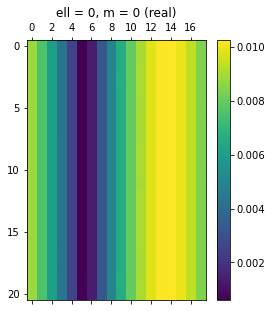

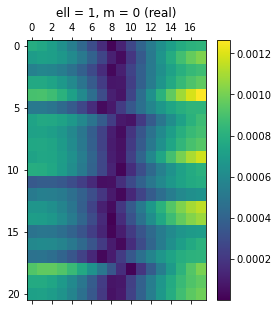

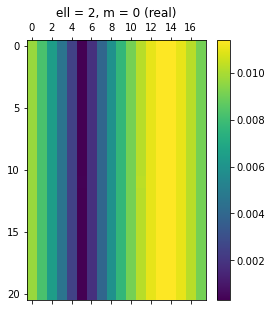

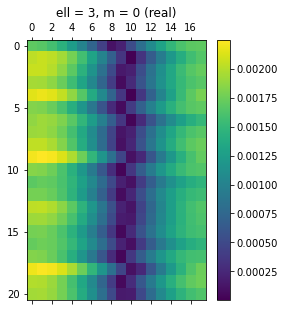

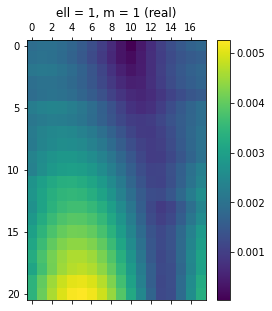

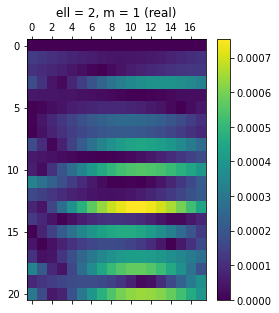

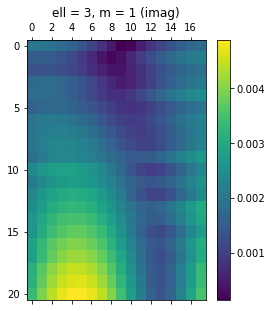

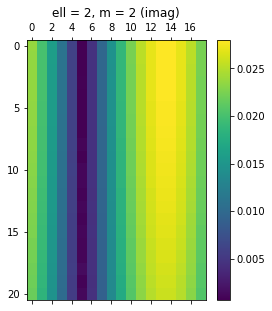

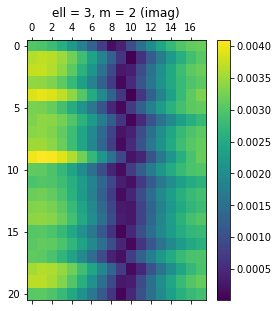

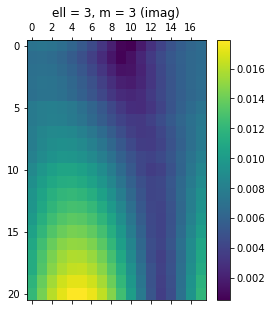

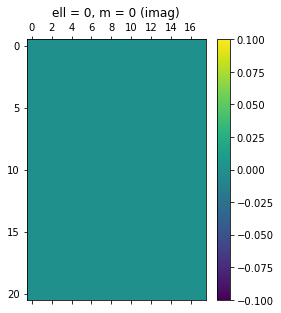

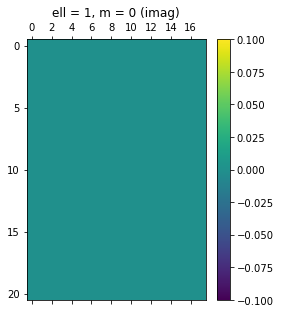

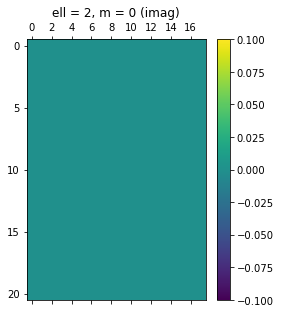

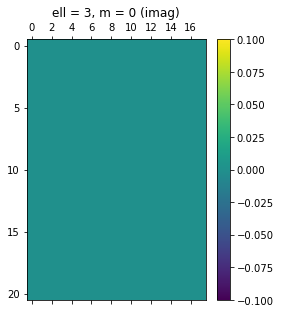

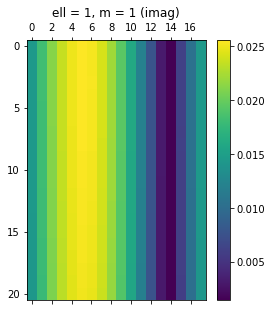

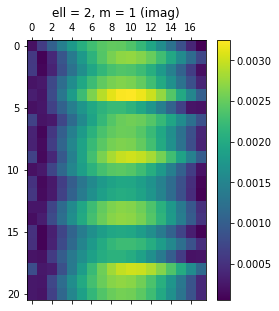

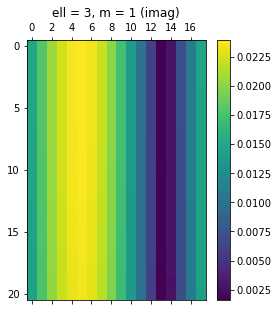

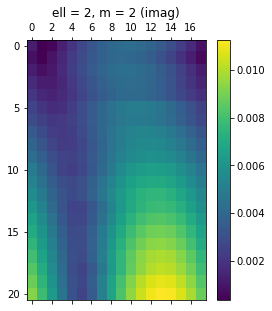

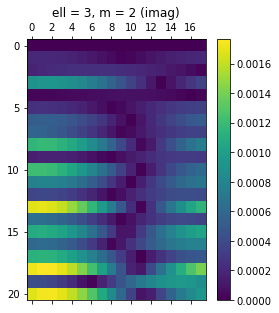

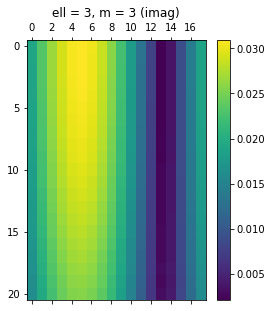

In [95]:
ant1, ant2 = 0, 4
Nmodes = ell.shape[0]
for i in range(vis_alm.shape[-1]):
    plt.matshow(np.abs(vis_alm[:,:,ant1,ant2,i]).T, aspect='auto')
    c = 'imag' if i > Nmodes // 2 else 'real'
        
    plt.title("ell = %d, m = %d (%s)" % (ell[i%Nmodes], m[i%Nmodes], c))
    plt.colorbar()
    plt.show()

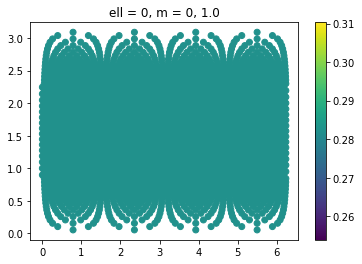

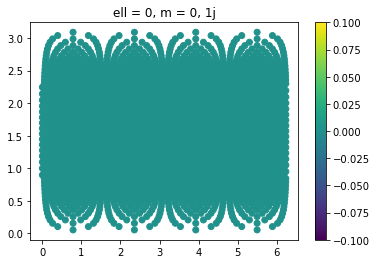

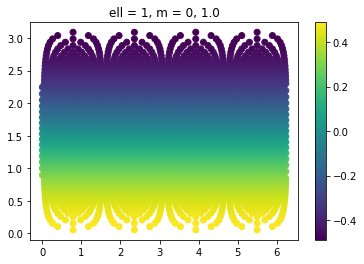

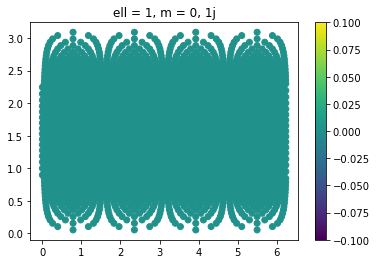

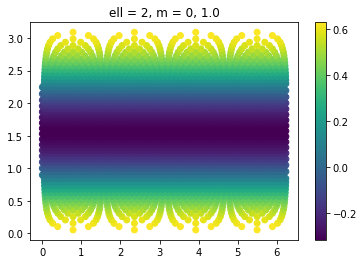

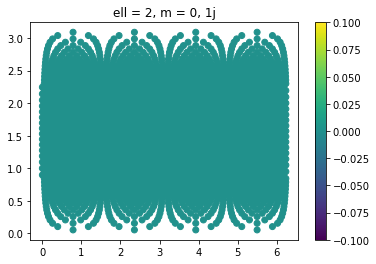

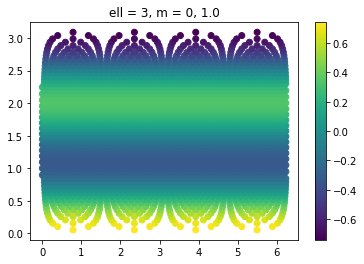

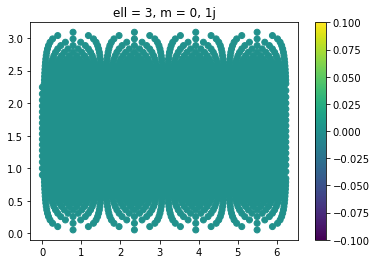

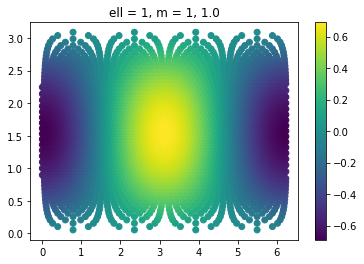

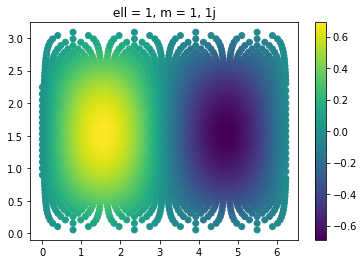

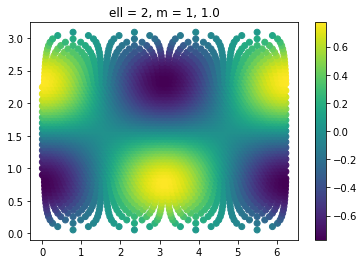

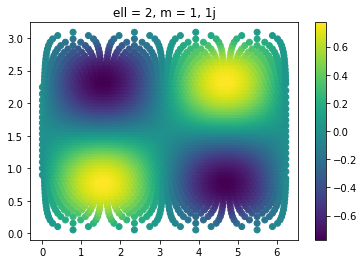

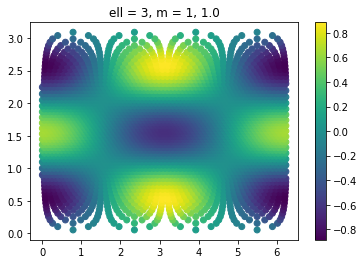

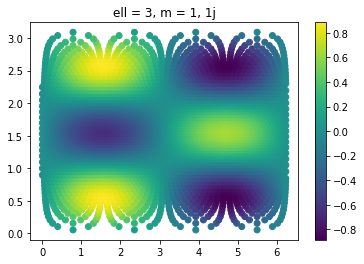

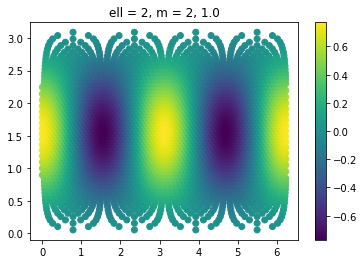

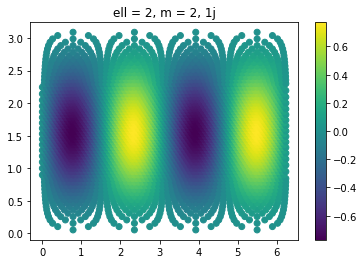

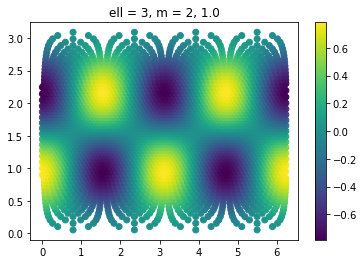

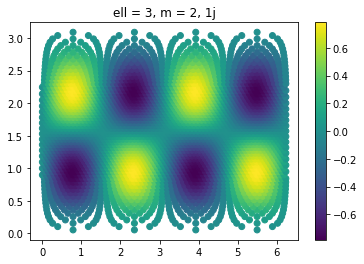

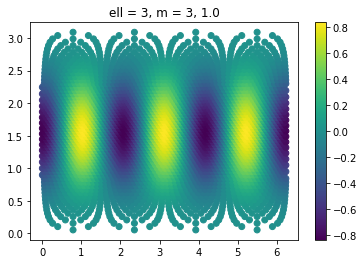

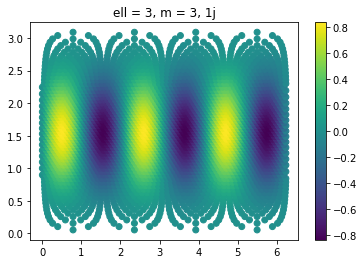

In [21]:
# Get Healpix pixel coords
nside = 16
npix = hp.nside2npix(nside)
pix_area = 4.*np.pi / npix # steradians per pixel
dec, ra = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=False)

# Array of ell, m values in healpy ordering
ell, m = hp.Alm().getlm(lmax=lmax)
alm = np.zeros(ell.size, dtype=np.complex128)
for n in range(ell.size):

    # Start with zero vector for all modes
    alm *= 0

    # Loop over real, imaginary values for this mode only
    for j, val in enumerate([1., 1.j]):

        # Make healpix map for this mode only
        alm[n] = val
        skymap = hp.alm2map(alm, nside=nside)
        
        plt.subplot(111)
        plt.scatter(ra, dec, c=skymap)
        plt.colorbar()
        plt.title("ell = %d, m = %d, %s" % (ell[n], m[n], val))
        plt.show()

In [22]:
# Freqs and LSTs
nside = 64
freqs = np.unique(uvd.freq_array)
lsts = np.unique(uvd.lst_array)

# Get Healpix pixel coords
npix = hp.nside2npix(nside)
pix_area = 4.*np.pi / npix # steradians per pixel
dec, ra = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=False)
dec = dec - 0.5*np.pi

# Dummy fluxes (one everywhere)
fluxes = np.ones((npix, freqs.size))

# Run simulation using the per-source simulation function, to get
# visibility contrib. from each pixel
beams = [pyuvsim.AnalyticBeam('gaussian', sigma=np.deg2rad(5.)) for ant in ant_pos]
vis_pix = hydra.vis_simulator.simulate_vis_per_source(ants=ant_pos,
                                  fluxes=fluxes,
                                  ra=ra,
                                  dec=dec,
                                  freqs=freqs,
                                  lsts=lsts,
                                  beams=beams,
                                  polarized=False,
                                  precision=2,
                                  latitude=latitude,
                                  multiprocess=False)

In [23]:
simulate_vis_per_source?

In [24]:
ra.min(), ra.max(), dec.min(), dec.max()

(0.0, 6.270913460876501, -1.5580384811972257, 1.5580384811972259)

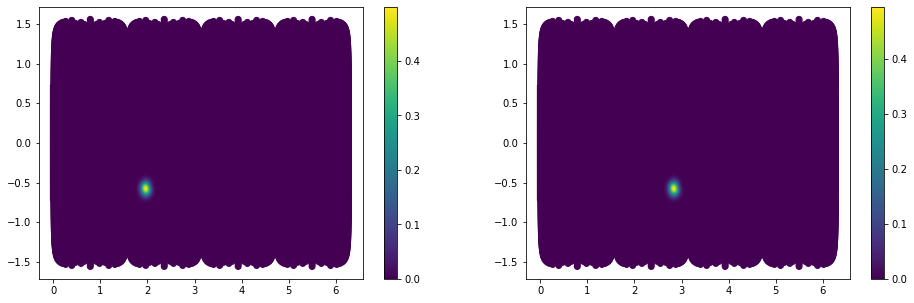

In [25]:
plt.subplot(121)
plt.scatter(ra, dec, c=(np.abs(vis_pix[0,0,0,0,:])))
plt.colorbar()

plt.subplot(122)
plt.scatter(ra, dec, c=(np.abs(vis_pix[0,-1,0,0,:])))
plt.colorbar()

#plt.yscale('log')
#plt.colorbar()
plt.gcf().set_size_inches((16., 5.))

ell = 2, m = 1


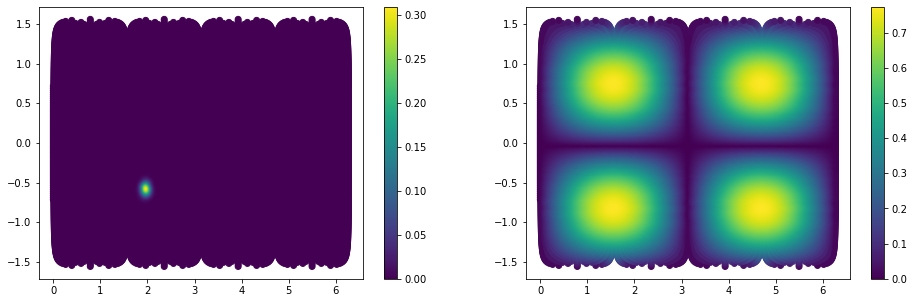

In [26]:
alm = np.zeros(ell.size, dtype=np.complex128)
nn = 5
alm[nn] = 1.j
print("ell = %d, m = %d" % (ell[nn], m[nn]))
skymap = hp.alm2map(alm, nside=nside)


plt.subplot(121)
plt.scatter(ra, dec, c=(np.abs(skymap * vis_pix[0,0,1,4,:])))
plt.colorbar()

plt.subplot(122)
plt.scatter(ra, dec, c=(np.abs(skymap)))
plt.colorbar()

#plt.yscale('log')
#plt.colorbar()
plt.gcf().set_size_inches((16., 5.))

In [24]:
lsts.shape

(21,)

# Resolution test

idx = 0, ell = 0, m = 0
idx = 1, ell = 1, m = 0
idx = 2, ell = 1, m = 1


Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


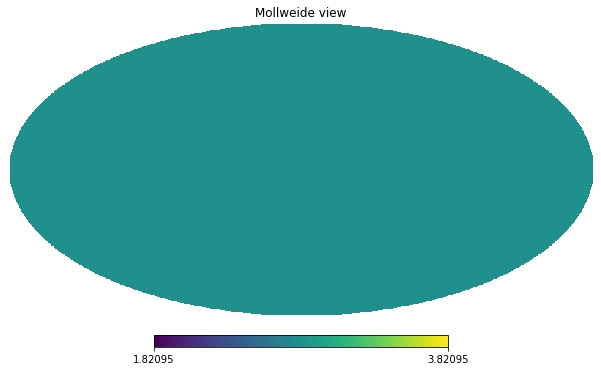

Simulation (diffuse) took 0.2 sec


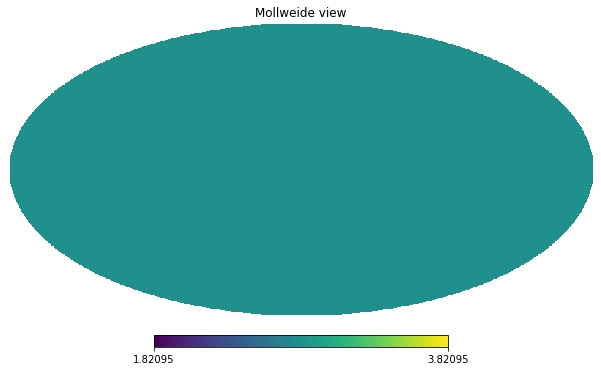

Simulation (diffuse) took 0.7 sec


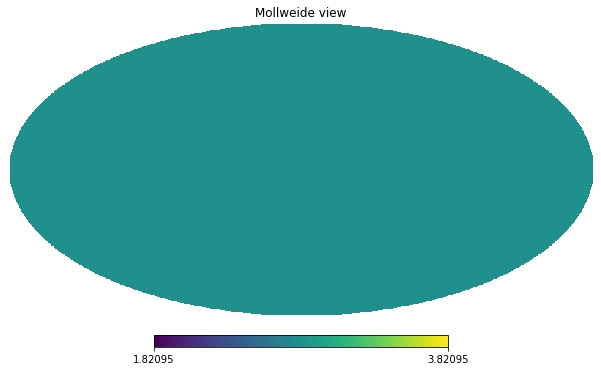

Simulation (diffuse) took 2.8 sec


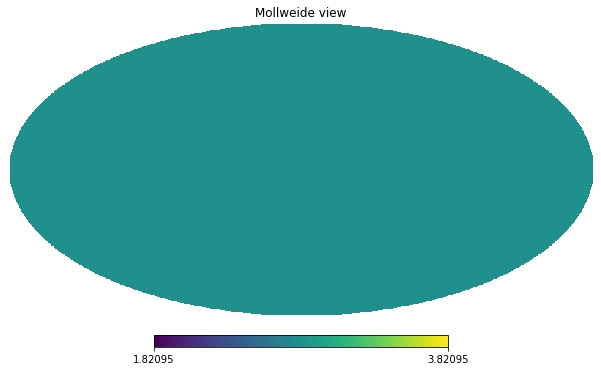

Simulation (diffuse) took 15.6 sec


In [200]:
ant_pos = {0: (0., 0., 0.), 
           1: (14., 0., 0.),
           #2: (0., 14., 0.),
           #3: (14., 14., 0.),
           #4: (40., 0., 0.),
          }
beams = [pyuvsim.AnalyticBeam('gaussian', sigma=np.deg2rad(20.)) for ant in ant_pos]

uvd = empty_uvdata(ants=ant_pos, nfreq=1, ntimes=50, bandwidth=11e6, 
                   integration_time=60., 
                   start_time=2458902.33333, start_freq=100e6)

# Array of ell, m values in healpy ordering
lmax = 1
ell, m = hp.Alm().getlm(lmax=lmax)
for n in range(ell.size):
    print("idx = %d, ell = %d, m = %d" % (n, ell[n], m[n]))
alm = np.zeros(ell.size, dtype=np.complex128)

ant1, ant2 = 0, 1

# Monopole
monopole_data = 0
alm *= 0.
alm[0] = 10. # Have to add monopole for viscpu!
viscpu_sh(uvd, alm, nside=64)
#y1 = uvd.get_data(ant1, ant2)
y1a = uvd.get_data(0, 0)
y1b = uvd.get_data(0, 1)

alm *= 0.
alm[0] = 10. # Have to add monopole for viscpu!
viscpu_sh(uvd, alm, nside=128)
y2a = uvd.get_data(0, 0)
y2b = uvd.get_data(0, 1)

alm *= 0.
alm[0] = 10. # Have to add monopole for viscpu!
viscpu_sh(uvd, alm, nside=256)
y3a = uvd.get_data(0, 0)
y3b = uvd.get_data(0, 1)

alm *= 0.
alm[0] = 10. # Have to add monopole for viscpu!
viscpu_sh(uvd, alm, nside=512)
y4a = uvd.get_data(0, 0)
y4b = uvd.get_data(0, 1)

Text(0.5, 0, 'LST [rad]')

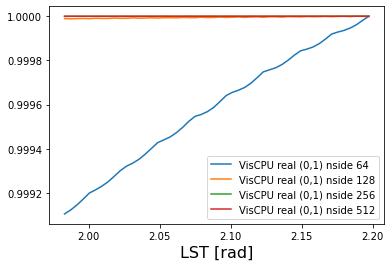

In [201]:
# Plot visibility vs LST
plt.subplot(111)
plt.plot(np.unique(uvd.lst_array), y1.real / y1.real.max(), label="VisCPU real (0,1) nside 64")
#plt.plot(np.unique(uvd.lst_array), uvd.get_data(0, 1).imag, label="VisCPU imag (0,1)")
plt.plot(np.unique(uvd.lst_array), y2.real / y2.real.max(), label="VisCPU real (0,1) nside 128")
plt.plot(np.unique(uvd.lst_array), y3.real / y3.real.max(), label="VisCPU real (0,1) nside 256")
plt.plot(np.unique(uvd.lst_array), y4.real / y4.real.max(), label="VisCPU real (0,1) nside 512")

plt.legend(loc='lower right')
plt.xlabel("LST [rad]", fontsize=16)
#plt.title("ell = %d, m = %d (%s)" % (ell[i], m[i]))

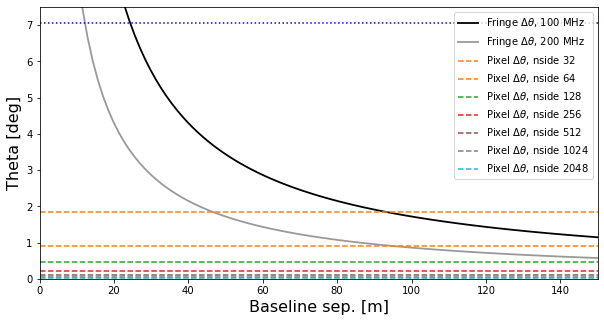

In [144]:
plt.subplot(111)

d_baseline = np.linspace(10., 150., 100)
#plt.plot(d_baseline, 11.8 * (14.6 / d_baseline), 'k-', lw=1.8, label=r"Fringe $\Delta \theta$")
plt.plot(d_baseline, (3e8 / 100e6) * 180./np.pi / d_baseline, 'k-', lw=1.8, label=r"Fringe $\Delta \theta$, 100 MHz")
plt.plot(d_baseline, (3e8 / 200e6) * 180./np.pi / d_baseline, 'k-', alpha=0.4, lw=1.8, label=r"Fringe $\Delta \theta$, 200 MHz")

from matplotlib.cm import tab10
for ns in [32, 64, 128, 256, 512, 1024, 2048]:
    
    plt.axhline(58.6 / ns, ls='dashed', color=tab10(np.sqrt(ns / 2048.)), 
                label=r"Pixel $\Delta \theta$, nside %d" % ns)

    
plt.axhline(1.2 * (3e8 / 200e6) * 180./np.pi / 14.6, color='b', ls='dotted')
plt.legend()
plt.xlabel("Baseline sep. [m]", fontsize=16)
plt.ylabel("Theta [deg]", fontsize=16)

plt.xlim((0., 150.))
plt.ylim((0., 7.5))

plt.gcf().set_size_inches(10., 5.)

In [136]:
np.sqrt(4.*np.pi * (180/np.pi)**2 / (12 * 64**2))

0.9161297098179749

In [143]:
1.2 * (3e8 / 100e6) * 180./np.pi / 14.6

14.12772645528057

In [204]:
# Hydra version
ell, m, vis_alm = simulate_vis_per_alm(lmax=1, 
                                                               nside=128, 
                                                               ants=ant_pos, 
                                                               freqs=np.unique(uvd.freq_array), 
                                                               lsts=np.unique(uvd.lst_array), 
                                                               beams=beams,
                                                               latitude=latitude,
                                                               multiprocess=False)
print("vis_alm:", vis_alm.dtype)

TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
vis_alm: complex128


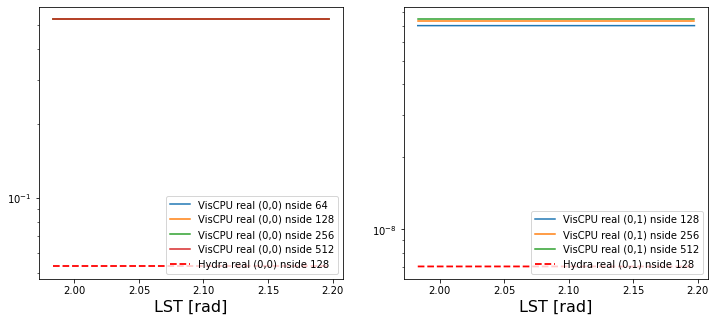

In [205]:
_lsts = np.unique(uvd.lst_array)

plt.subplot(121)

plt.plot(_lsts, y1a.real, label="VisCPU real (0,0) nside 64")
plt.plot(_lsts, y2a.real, label="VisCPU real (0,0) nside 128")
plt.plot(_lsts, y3a.real, label="VisCPU real (0,0) nside 256")
plt.plot(_lsts, y4a.real, label="VisCPU real (0,0) nside 512")

plt.plot(_lsts, vis_alm[0,:,0,0,0].real, 'r--', lw=1.8, label="Hydra real (0,0) nside 128")

plt.yscale('log')
plt.legend(loc='lower right')
plt.xlabel("LST [rad]", fontsize=16)

plt.subplot(122)
#plt.plot(_lsts, y1b.real / y1b.real.max(), label="VisCPU real (0,1) nside 64")
plt.plot(_lsts, y2b.real, label="VisCPU real (0,1) nside 128")
plt.plot(_lsts, y3b.real, label="VisCPU real (0,1) nside 256")
plt.plot(_lsts, y4b.real, label="VisCPU real (0,1) nside 512")

plt.plot(_lsts, vis_alm[0,:,0,1,0].real, 'r--', lw=1.8, label="Hydra real (0,1) nside 128")

plt.yscale('log')
plt.legend(loc='lower right')
plt.xlabel("LST [rad]", fontsize=16)

plt.gcf().set_size_inches((12., 5.))


In [203]:
y2b.real.max() / vis_alm[0,:,0,1,0].real.max(), y2b.imag.max() / vis_alm[0,:,0,1,0].imag.max()

(9.999994739886155, 9.999828500515083)

In [196]:
y2a.real.max() / vis_alm[0,:,0,0,0].real.max(), y2a.imag.max() / vis_alm[0,:,0,0,0].imag.max()

invalid value encountered in double_scalars


(3.994722401012602e-05, nan)

In [206]:
y2a.real.max(), y2b.real.max()

(0.5290883245734378, 7.019451233798322e-08)

In [195]:
npix = hp.nside2npix(128)
pix_area = 4.*np.pi / npix # steradians per pixel
pix_area

6.391586616190171e-05

In [191]:
beams[0].interp(np.array([0.,]), np.array([0.5,]), np.linspace(100.e6, 120e6, 1))

(array([[[[[0.        ]],
 
          [[0.35848194]]]],
 
 
 
        [[[[0.35848194]],
 
          [[0.        ]]]]]),
 None)

Object `interp` not found.


## Test plot comparison

idx = 0, ell = 0, m = 0
idx = 1, ell = 1, m = 0
idx = 2, ell = 2, m = 0
idx = 3, ell = 1, m = 1
idx = 4, ell = 2, m = 1
idx = 5, ell = 2, m = 2


Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


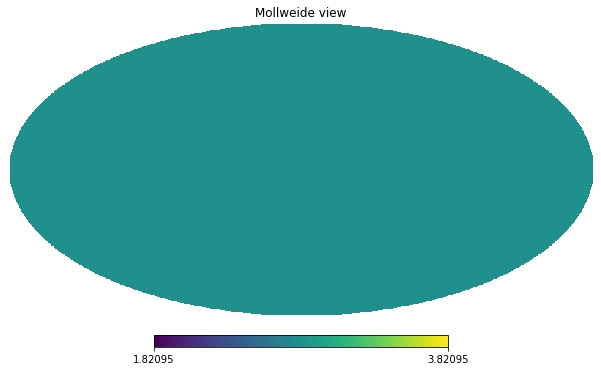

Simulation (diffuse) took 17.7 sec


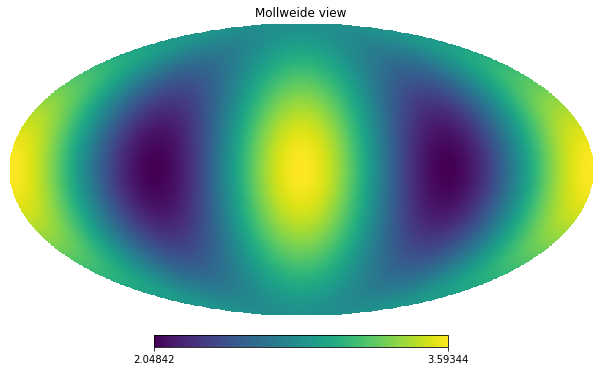

Simulation (diffuse) took 19.9 sec


In [238]:
ant_pos = {0: (0., 0., 0.), 
           1: (14., 0., 0.),
           #2: (0., 14., 0.),
           #3: (14., 14., 0.),
           #4: (40., 0., 0.),
          }
beams = [pyuvsim.AnalyticBeam('gaussian', sigma=np.deg2rad(20.)) for ant in ant_pos]

uvd = empty_uvdata(ants=ant_pos, nfreq=26, ntimes=50, bandwidth=26e6, 
                   integration_time=60., 
                   start_time=2458902.33333, start_freq=100e6)

# Array of ell, m values in healpy ordering
lmax = 2
ell, m = hp.Alm().getlm(lmax=lmax)
for n in range(ell.size):
    print("idx = %d, ell = %d, m = %d" % (n, ell[n], m[n]))
alm = np.zeros(ell.size, dtype=np.complex128)
ant1, ant2 = 0, 1

# Monopole
monopole_data = 0
alm *= 0.
alm[0] = 10. # Have to add monopole for viscpu!
viscpu_sh(uvd, alm, nside=128)
#y1 = uvd.get_data(ant1, ant2)
mono1a = uvd.get_data(0, 0).copy()
mono1b = uvd.get_data(0, 1).copy()

alm *= 0.
alm[0] = 10. # need to keep monopole
alm[5] = 1.
viscpu_sh(uvd, alm, nside=128)
y1a = uvd.get_data(0, 0).copy()
y1b = uvd.get_data(0, 1).copy()

In [210]:
# Hydra version
ell, m, vis_alm = simulate_vis_per_alm(lmax=2, 
                                                               nside=128, 
                                                               ants=ant_pos, 
                                                               freqs=np.unique(uvd.freq_array), 
                                                               lsts=np.unique(uvd.lst_array), 
                                                               beams=beams,
                                                               latitude=latitude,
                                                               multiprocess=False)
print("vis_alm:", vis_alm.dtype)

TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
TYPES complex128 float64 complex128
vis_alm: complex128


In [236]:
# Hydra version
ell2, m2, vis_alm2 = hydra.vis_simulator.simulate_vis_per_alm(lmax=2, 
                                                               nside=64, 
                                                               ants=ant_pos, 
                                                               freqs=np.unique(uvd.freq_array), 
                                                               lsts=np.unique(uvd.lst_array), 
                                                               beams=beams,
                                                               latitude=latitude,
                                                               multiprocess=False,
                                                               precision=2)

In [231]:
# ell = 2, m = 2
ell[5], m[5]

(2, 2)

ValueError: operands could not be broadcast together with shapes (26,50) (3,11) 

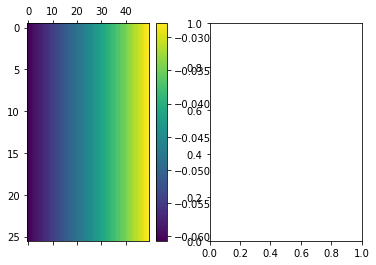

In [237]:
plt.subplot(121)
plt.matshow((y1a - mono1a).real.T, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(vis_alm[:,:,0,0,5].real - vis_alm2[:,:,0,0,5].real, aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((12., 5.))

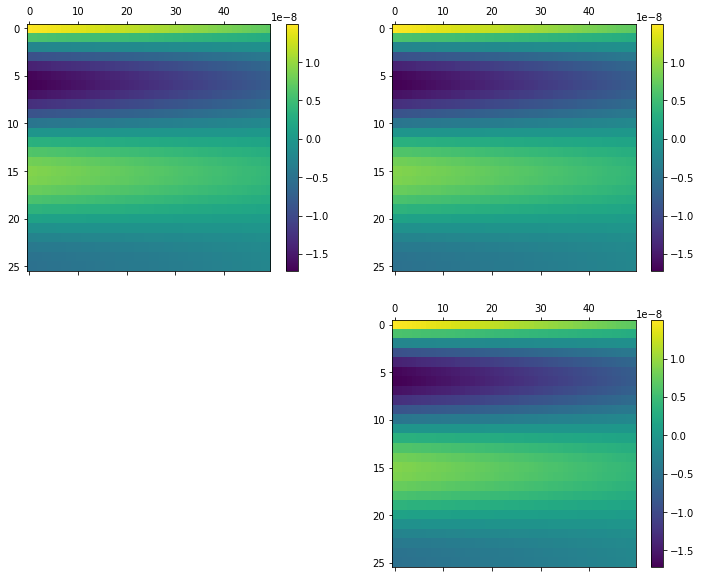

In [235]:
plt.subplot(221)
plt.matshow((y1b - mono1b).real.T, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(222)
plt.matshow(vis_alm[:,:,0,1,5].real, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(224)
plt.matshow(vis_alm2[:,:,0,1,5].real, aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((12., 10.))